In [1]:
from google.colab import drive
import pandas as pd

# This will prompt for authorization to access your Google Drive
drive.mount('/content/drive')

# Update the file path to the location where you uploaded your CSV in Google Drive
file_path = '/content/drive/My Drive/Thesis/df-BERT_cat.csv'

# Read the CSV file
df = pd.read_csv(file_path)

# Drop the first column (if it's an unwanted index column)
df = df.drop(df.columns[0], axis=1)

# Display the column names
df.columns.tolist()


Mounted at /content/drive


['numerical_price',
 'embeddings',
 'num_bedrooms',
 'num_rooms',
 'building_type_Bestaande bouw',
 'building_type_Nieuwbouw',
 'building_type_na',
 'tag_k.k.',
 'tag_v.o.n.',
 'house_category_Appartement',
 'house_category_Bungalow',
 'house_category_Eengezinswoning',
 'house_category_Grachtenpand',
 'house_category_Herenhuis',
 'house_category_Landhuis',
 'house_category_Other',
 'house_category_Unknown',
 'house_category_Villa',
 'house_category_Woonboerderij',
 'house_category_Woonboot',
 'energy_label_encoded',
 'size_scaled',
 'longitude_scaled',
 'latitude_scaled']

In [2]:
import pandas as pd
import numpy as np
from ast import literal_eval



df["embeddings"] = df["embeddings"].apply(literal_eval).apply(np.array)

# Separating the target variable and embeddings
x = df["embeddings"]
y = df['numerical_price']

# Dropping the 'ada_embedding_eng' column from df
z = df.drop(["embeddings", "numerical_price"], axis=1)


# Deleting original dataframe for memory purpose
del df

# Explode the embedding arrays into separate columns
x = x.apply(pd.Series)

# Concatenating the exploded embeddings with the rest of the data
concatenated_df = pd.concat([x, z], axis=1).reset_index(drop=True)

In [4]:
concatenated_df.columns = concatenated_df.columns.astype(str)
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(concatenated_df, y, test_size=0.2, random_state=42)
# Now, sample 10000 instances from the remaining training set for hyperparameter tuning
x_train = x_train.sample(10000, random_state=42)
y_train = y_train.loc[x_train.index]


In [5]:
!pip install optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2, l1_l2
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import numpy as np
import optuna

def Objective_nn_mixed(trial):
    # Hyperparameters to tune
    learning_rate = trial.suggest_float("learning_rate", 0.0001, 0.01, log=False)
    neurons_layer_1 = trial.suggest_int("neurons_layer_1", 16, 1024, step=16)
    neurons_layer_2 = trial.suggest_int("neurons_layer_2", 16, 512, step=16)
    neurons_layer_3 = trial.suggest_int("neurons_layer_3", 16, 256, step=16)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
    epochs = trial.suggest_int("epochs", 5, 100)
    regularization = trial.suggest_categorical("regularization", ["none", "l1", "l2", "l1_l2"])
    l1_reg = trial.suggest_float("l1_reg", 1e-5, 1e-1, log=True) if regularization in ["l1", "l1_l2"] else 0
    l2_reg = trial.suggest_float("l2_reg", 1e-5, 1e-1, log=True) if regularization in ["l2", "l1_l2"] else 0

    # KFold Cross-validation
    kf = KFold(n_splits=5)
    r2_scores = []

    for train_index, test_index in kf.split(x_train):
        X_train_fold, X_test_fold = x_train[train_index], x_train[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]



        # Build model
        model = Sequential()
        model.add(Dense(neurons_layer_1, activation='relu', input_shape=(X_train_fold.shape[1],),
                        kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg) if regularization != "none" else None))
        model.add(Dense(neurons_layer_2, activation='relu',
                        kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg) if regularization != "none" else None))
        model.add(Dense(neurons_layer_3, activation='relu',
                        kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg) if regularization != "none" else None))
        model.add(Dense(1, activation='linear'))

        # Compile model
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='mean_squared_error')

        # Scaling y_train
        scaler = StandardScaler()
        y_train_scaled = scaler.fit_transform(y_train_fold.reshape(-1, 1)).flatten()

        # Train model
        model.fit(X_train_fold, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=0)

        # Predict and evaluate
        y_pred_scaled = model.predict(X_test_fold)
        y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

        r2 = r2_score(y_test_fold, y_pred)
        r2_scores.append(r2)

    return np.mean(r2_scores)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.7 MB/s eta 0:00:00


In [6]:
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

# Ensure y_train and y_test are 1D arrays
# This step is only necessary if y_train or y_test are not already 1D arrays
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

# Check the shapes again after any necessary adjustments
print("Adjusted y_train shape:", y_train.shape)
print("Adjusted y_test shape:", y_test.shape)

Adjusted y_train shape: (10000,)
Adjusted y_test shape: (14403,)


In [7]:
study_rf = optuna.create_study(directions=['maximize'])
study_rf.optimize(Objective_nn_mixed, n_trials=50)

[I 2024-01-07 13:12:00,767] A new study created in memory with name: no-name-2b241ec7-83d6-464f-8b94-60ec21e4c1a3


63/63 [==============================] - 0s 5ms/step


[I 2024-01-07 13:17:45,011] Trial 0 finished with value: 0.404800228818177 and parameters: {'learning_rate': 0.006850479069479804, 'neurons_layer_1': 864, 'neurons_layer_2': 160, 'neurons_layer_3': 128, 'batch_size': 128, 'epochs': 34, 'regularization': 'l2', 'l2_reg': 0.049266118830302456}. Best is trial 0 with value: 0.404800228818177.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 13:25:27,864] Trial 1 finished with value: 0.35933705138679034 and parameters: {'learning_rate': 0.009706301791559025, 'neurons_layer_1': 688, 'neurons_layer_2': 80, 'neurons_layer_3': 80, 'batch_size': 16, 'epochs': 17, 'regularization': 'l1_l2', 'l1_reg': 0.009356321879138882, 'l2_reg': 0.0164675427318661}. Best is trial 0 with value: 0.404800228818177.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 13:31:43,429] Trial 2 finished with value: 0.42357559028445235 and parameters: {'learning_rate': 0.005821551665402372, 'neurons_layer_1': 96, 'neurons_layer_2': 192, 'neurons_layer_3': 192, 'batch_size': 16, 'epochs': 50, 'regularization': 'l2', 'l2_reg': 0.019742502088646127}. Best is trial 2 with value: 0.42357559028445235.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 13:35:03,497] Trial 3 finished with value: 0.5023334900635655 and parameters: {'learning_rate': 0.0047721670721423285, 'neurons_layer_1': 736, 'neurons_layer_2': 256, 'neurons_layer_3': 48, 'batch_size': 64, 'epochs': 21, 'regularization': 'l2', 'l2_reg': 0.000502357254336495}. Best is trial 3 with value: 0.5023334900635655.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 13:46:06,374] Trial 4 finished with value: 0.5743556899842032 and parameters: {'learning_rate': 0.007402052786559843, 'neurons_layer_1': 672, 'neurons_layer_2': 304, 'neurons_layer_3': 96, 'batch_size': 128, 'epochs': 100, 'regularization': 'l2', 'l2_reg': 0.004327453696758924}. Best is trial 4 with value: 0.5743556899842032.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 13:51:06,387] Trial 5 finished with value: 0.1921317094470436 and parameters: {'learning_rate': 0.006083700385505051, 'neurons_layer_1': 176, 'neurons_layer_2': 496, 'neurons_layer_3': 16, 'batch_size': 32, 'epochs': 43, 'regularization': 'l2', 'l2_reg': 0.0002458550846977143}. Best is trial 4 with value: 0.5743556899842032.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 13:55:39,005] Trial 6 finished with value: 0.5571333061475578 and parameters: {'learning_rate': 0.007465998821639808, 'neurons_layer_1': 144, 'neurons_layer_2': 384, 'neurons_layer_3': 240, 'batch_size': 128, 'epochs': 89, 'regularization': 'l2', 'l2_reg': 0.004831928201496838}. Best is trial 4 with value: 0.5743556899842032.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 14:03:10,296] Trial 7 finished with value: 0.6435625616065264 and parameters: {'learning_rate': 0.0007113849167409287, 'neurons_layer_1': 528, 'neurons_layer_2': 80, 'neurons_layer_3': 192, 'batch_size': 64, 'epochs': 75, 'regularization': 'l1', 'l1_reg': 0.0006866048387129584}. Best is trial 7 with value: 0.6435625616065264.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 14:18:22,978] Trial 8 finished with value: 0.517440100203441 and parameters: {'learning_rate': 0.004552462656218839, 'neurons_layer_1': 512, 'neurons_layer_2': 96, 'neurons_layer_3': 32, 'batch_size': 16, 'epochs': 46, 'regularization': 'l1_l2', 'l1_reg': 0.0010735873430048352, 'l2_reg': 0.002318707517537101}. Best is trial 7 with value: 0.6435625616065264.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 14:43:34,778] Trial 9 finished with value: 0.19744693354252968 and parameters: {'learning_rate': 0.006446525213276076, 'neurons_layer_1': 656, 'neurons_layer_2': 432, 'neurons_layer_3': 160, 'batch_size': 32, 'epochs': 88, 'regularization': 'l1', 'l1_reg': 0.009704466975206535}. Best is trial 7 with value: 0.6435625616065264.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 14:49:03,860] Trial 10 finished with value: 0.6919832540399792 and parameters: {'learning_rate': 0.0004093823362208474, 'neurons_layer_1': 400, 'neurons_layer_2': 16, 'neurons_layer_3': 256, 'batch_size': 64, 'epochs': 70, 'regularization': 'l1', 'l1_reg': 1.2767534738213131e-05}. Best is trial 10 with value: 0.6919832540399792.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 14:54:26,824] Trial 11 finished with value: 0.6955588855616291 and parameters: {'learning_rate': 0.00021483873500531732, 'neurons_layer_1': 400, 'neurons_layer_2': 16, 'neurons_layer_3': 256, 'batch_size': 64, 'epochs': 69, 'regularization': 'l1', 'l1_reg': 1.471196701531699e-05}. Best is trial 11 with value: 0.6955588855616291.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 14:59:31,317] Trial 12 finished with value: 0.7078161879813638 and parameters: {'learning_rate': 0.00014751463560217556, 'neurons_layer_1': 336, 'neurons_layer_2': 16, 'neurons_layer_3': 256, 'batch_size': 64, 'epochs': 69, 'regularization': 'l1', 'l1_reg': 1.188728382306518e-05}. Best is trial 12 with value: 0.7078161879813638.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 15:04:33,295] Trial 13 finished with value: 0.6901589254496955 and parameters: {'learning_rate': 0.00230307426008383, 'neurons_layer_1': 304, 'neurons_layer_2': 32, 'neurons_layer_3': 224, 'batch_size': 64, 'epochs': 65, 'regularization': 'none'}. Best is trial 12 with value: 0.7078161879813638.


63/63 [==============================] - 0s 4ms/step


[I 2024-01-07 15:09:14,744] Trial 14 finished with value: 0.648376860032452 and parameters: {'learning_rate': 0.0025205148125782492, 'neurons_layer_1': 304, 'neurons_layer_2': 176, 'neurons_layer_3': 208, 'batch_size': 64, 'epochs': 61, 'regularization': 'l1', 'l1_reg': 1.0247266494948608e-05}. Best is trial 12 with value: 0.7078161879813638.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 15:15:38,977] Trial 15 finished with value: 0.6673365943697993 and parameters: {'learning_rate': 0.0019622677244844626, 'neurons_layer_1': 416, 'neurons_layer_2': 16, 'neurons_layer_3': 256, 'batch_size': 64, 'epochs': 78, 'regularization': 'l1', 'l1_reg': 9.015571636204055e-05}. Best is trial 12 with value: 0.7078161879813638.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 15:25:38,701] Trial 16 finished with value: 0.6614349265322055 and parameters: {'learning_rate': 0.0034087180713383335, 'neurons_layer_1': 992, 'neurons_layer_2': 144, 'neurons_layer_3': 160, 'batch_size': 64, 'epochs': 58, 'regularization': 'none'}. Best is trial 12 with value: 0.7078161879813638.


63/63 [==============================] - 0s 4ms/step


[I 2024-01-07 15:28:37,452] Trial 17 finished with value: 0.6554481879953007 and parameters: {'learning_rate': 0.0012391065455181574, 'neurons_layer_1': 256, 'neurons_layer_2': 256, 'neurons_layer_3': 224, 'batch_size': 64, 'epochs': 32, 'regularization': 'l1', 'l1_reg': 7.445994942344734e-05}. Best is trial 12 with value: 0.7078161879813638.


63/63 [==============================] - 0s 1ms/step


[I 2024-01-07 15:28:58,123] Trial 18 finished with value: 0.5000209767250821 and parameters: {'learning_rate': 0.003669261284038111, 'neurons_layer_1': 32, 'neurons_layer_2': 96, 'neurons_layer_3': 144, 'batch_size': 32, 'epochs': 5, 'regularization': 'l1', 'l1_reg': 6.57191615251495e-05}. Best is trial 12 with value: 0.7078161879813638.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 15:40:22,044] Trial 19 finished with value: -0.00027341887494434223 and parameters: {'learning_rate': 0.00017135968832689675, 'neurons_layer_1': 480, 'neurons_layer_2': 336, 'neurons_layer_3': 192, 'batch_size': 64, 'epochs': 83, 'regularization': 'l1', 'l1_reg': 0.08238549362679475}. Best is trial 12 with value: 0.7078161879813638.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 15:54:52,817] Trial 20 finished with value: 0.6679977013683502 and parameters: {'learning_rate': 0.0017685368136458077, 'neurons_layer_1': 592, 'neurons_layer_2': 224, 'neurons_layer_3': 256, 'batch_size': 64, 'epochs': 98, 'regularization': 'l1_l2', 'l1_reg': 2.756005049697332e-05, 'l2_reg': 1.4650427180812393e-05}. Best is trial 12 with value: 0.7078161879813638.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 16:00:19,235] Trial 21 finished with value: 0.7052693724604447 and parameters: {'learning_rate': 0.00012590300838901037, 'neurons_layer_1': 384, 'neurons_layer_2': 16, 'neurons_layer_3': 256, 'batch_size': 64, 'epochs': 70, 'regularization': 'l1', 'l1_reg': 1.006924885834708e-05}. Best is trial 12 with value: 0.7078161879813638.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 16:05:29,213] Trial 22 finished with value: 0.6314786132105793 and parameters: {'learning_rate': 0.001125873145086355, 'neurons_layer_1': 352, 'neurons_layer_2': 48, 'neurons_layer_3': 224, 'batch_size': 64, 'epochs': 68, 'regularization': 'l1', 'l1_reg': 3.6417215149436184e-05}. Best is trial 12 with value: 0.7078161879813638.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 16:09:59,717] Trial 23 finished with value: 0.678210570328939 and parameters: {'learning_rate': 0.0001658135648090753, 'neurons_layer_1': 224, 'neurons_layer_2': 128, 'neurons_layer_3': 240, 'batch_size': 64, 'epochs': 57, 'regularization': 'l1', 'l1_reg': 0.00025411616746163476}. Best is trial 12 with value: 0.7078161879813638.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 16:15:56,328] Trial 24 finished with value: 0.6210276198827034 and parameters: {'learning_rate': 0.003046845922708979, 'neurons_layer_1': 384, 'neurons_layer_2': 64, 'neurons_layer_3': 256, 'batch_size': 64, 'epochs': 76, 'regularization': 'none'}. Best is trial 12 with value: 0.7078161879813638.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 16:22:29,063] Trial 25 finished with value: 0.6797976914565247 and parameters: {'learning_rate': 0.0014819994058511863, 'neurons_layer_1': 448, 'neurons_layer_2': 112, 'neurons_layer_3': 208, 'batch_size': 64, 'epochs': 70, 'regularization': 'l1', 'l1_reg': 1.0102606040704175e-05}. Best is trial 12 with value: 0.7078161879813638.


63/63 [==============================] - 0s 4ms/step


[I 2024-01-07 16:37:14,744] Trial 26 finished with value: 0.6803423364476876 and parameters: {'learning_rate': 0.0009148005310696557, 'neurons_layer_1': 592, 'neurons_layer_2': 16, 'neurons_layer_3': 176, 'batch_size': 32, 'epochs': 84, 'regularization': 'l1', 'l1_reg': 0.00020677616731187742}. Best is trial 12 with value: 0.7078161879813638.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 16:47:56,583] Trial 27 finished with value: 0.10259887383812986 and parameters: {'learning_rate': 0.009154444059052013, 'neurons_layer_1': 304, 'neurons_layer_2': 48, 'neurons_layer_3': 240, 'batch_size': 16, 'epochs': 54, 'regularization': 'l1', 'l1_reg': 2.777716164094376e-05}. Best is trial 12 with value: 0.7078161879813638.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 16:50:39,914] Trial 28 finished with value: 0.6658114964336347 and parameters: {'learning_rate': 0.00286610988485471, 'neurons_layer_1': 224, 'neurons_layer_2': 208, 'neurons_layer_3': 112, 'batch_size': 128, 'epochs': 63, 'regularization': 'l1', 'l1_reg': 2.1921820805311057e-05}. Best is trial 12 with value: 0.7078161879813638.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 16:56:17,170] Trial 29 finished with value: 0.6301254307162354 and parameters: {'learning_rate': 0.004066458556591846, 'neurons_layer_1': 800, 'neurons_layer_2': 144, 'neurons_layer_3': 208, 'batch_size': 128, 'epochs': 45, 'regularization': 'l1_l2', 'l1_reg': 0.00014356011543589043, 'l2_reg': 4.0487323431214144e-05}. Best is trial 12 with value: 0.7078161879813638.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 16:59:32,462] Trial 30 finished with value: 0.6444984941523147 and parameters: {'learning_rate': 0.0017065671636313797, 'neurons_layer_1': 560, 'neurons_layer_2': 64, 'neurons_layer_3': 240, 'batch_size': 64, 'epochs': 34, 'regularization': 'none'}. Best is trial 12 with value: 0.7078161879813638.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 17:05:11,641] Trial 31 finished with value: 0.6951117538954014 and parameters: {'learning_rate': 0.00018065088389837943, 'neurons_layer_1': 384, 'neurons_layer_2': 16, 'neurons_layer_3': 256, 'batch_size': 64, 'epochs': 72, 'regularization': 'l1', 'l1_reg': 1.0646166631661747e-05}. Best is trial 12 with value: 0.7078161879813638.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 17:10:54,741] Trial 32 finished with value: 0.6484215274478154 and parameters: {'learning_rate': 0.0008689740877919809, 'neurons_layer_1': 368, 'neurons_layer_2': 16, 'neurons_layer_3': 256, 'batch_size': 64, 'epochs': 74, 'regularization': 'l1', 'l1_reg': 2.5472435172980184e-05}. Best is trial 12 with value: 0.7078161879813638.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 17:19:01,288] Trial 33 finished with value: 0.7111544448076279 and parameters: {'learning_rate': 0.0001700971350850996, 'neurons_layer_1': 448, 'neurons_layer_2': 64, 'neurons_layer_3': 224, 'batch_size': 64, 'epochs': 81, 'regularization': 'l1', 'l1_reg': 1.0753716213280884e-05}. Best is trial 33 with value: 0.7111544448076279.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 17:40:21,867] Trial 34 finished with value: 0.6942688703002551 and parameters: {'learning_rate': 0.0006755922808297868, 'neurons_layer_1': 464, 'neurons_layer_2': 64, 'neurons_layer_3': 224, 'batch_size': 16, 'epochs': 81, 'regularization': 'l1', 'l1_reg': 4.591538656798455e-05}. Best is trial 33 with value: 0.7111544448076279.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 17:47:06,825] Trial 35 finished with value: 0.6470032771614852 and parameters: {'learning_rate': 0.0022751415892726637, 'neurons_layer_1': 320, 'neurons_layer_2': 112, 'neurons_layer_3': 240, 'batch_size': 64, 'epochs': 93, 'regularization': 'l1', 'l1_reg': 1.9474719098962888e-05}. Best is trial 33 with value: 0.7111544448076279.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 17:49:51,265] Trial 36 finished with value: 0.6124307838524901 and parameters: {'learning_rate': 0.005362550724540975, 'neurons_layer_1': 112, 'neurons_layer_2': 48, 'neurons_layer_3': 208, 'batch_size': 64, 'epochs': 52, 'regularization': 'l1_l2', 'l1_reg': 0.0004905577979197668, 'l2_reg': 0.00011135398588678884}. Best is trial 33 with value: 0.7111544448076279.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 17:52:26,149] Trial 37 finished with value: 0.5322518256816824 and parameters: {'learning_rate': 0.0013439021011734799, 'neurons_layer_1': 256, 'neurons_layer_2': 80, 'neurons_layer_3': 176, 'batch_size': 128, 'epochs': 65, 'regularization': 'l2', 'l2_reg': 0.09951632188248821}. Best is trial 33 with value: 0.7111544448076279.


63/63 [==============================] - 0s 4ms/step


[I 2024-01-07 18:17:40,850] Trial 38 finished with value: 0.68554065374665 and parameters: {'learning_rate': 0.0006703903512005646, 'neurons_layer_1': 448, 'neurons_layer_2': 160, 'neurons_layer_3': 64, 'batch_size': 16, 'epochs': 92, 'regularization': 'l1', 'l1_reg': 1.7008958954379226e-05}. Best is trial 33 with value: 0.7111544448076279.


63/63 [==============================] - 0s 5ms/step


[I 2024-01-07 18:27:37,425] Trial 39 finished with value: 0.6575109320408854 and parameters: {'learning_rate': 0.008606046088859324, 'neurons_layer_1': 512, 'neurons_layer_2': 304, 'neurons_layer_3': 224, 'batch_size': 64, 'epochs': 81, 'regularization': 'l2', 'l2_reg': 1.0519120589152686e-05}. Best is trial 33 with value: 0.7111544448076279.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 18:38:52,478] Trial 40 finished with value: 0.5900799659541514 and parameters: {'learning_rate': 0.0019347962120228423, 'neurons_layer_1': 176, 'neurons_layer_2': 512, 'neurons_layer_3': 128, 'batch_size': 32, 'epochs': 87, 'regularization': 'l1', 'l1_reg': 0.0020444431484832547}. Best is trial 33 with value: 0.7111544448076279.


63/63 [==============================] - 0s 2ms/step


[I 2024-01-07 18:44:32,116] Trial 41 finished with value: 0.6849647875377917 and parameters: {'learning_rate': 0.0003696373756738787, 'neurons_layer_1': 400, 'neurons_layer_2': 32, 'neurons_layer_3': 256, 'batch_size': 64, 'epochs': 70, 'regularization': 'l1', 'l1_reg': 1.0404869234142214e-05}. Best is trial 33 with value: 0.7111544448076279.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 18:50:03,162] Trial 42 finished with value: 0.6726435557491471 and parameters: {'learning_rate': 0.00033827549748750586, 'neurons_layer_1': 336, 'neurons_layer_2': 96, 'neurons_layer_3': 240, 'batch_size': 64, 'epochs': 74, 'regularization': 'l1', 'l1_reg': 4.098354469668433e-05}. Best is trial 33 with value: 0.7111544448076279.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 18:58:54,458] Trial 43 finished with value: 0.7123369183932597 and parameters: {'learning_rate': 0.00011723245844623722, 'neurons_layer_1': 624, 'neurons_layer_2': 32, 'neurons_layer_3': 256, 'batch_size': 64, 'epochs': 78, 'regularization': 'l1', 'l1_reg': 1.802535830576335e-05}. Best is trial 43 with value: 0.7123369183932597.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 19:07:57,997] Trial 44 finished with value: 0.693247737735836 and parameters: {'learning_rate': 0.0011469412852178717, 'neurons_layer_1': 704, 'neurons_layer_2': 48, 'neurons_layer_3': 240, 'batch_size': 64, 'epochs': 61, 'regularization': 'l1', 'l1_reg': 1.861462662282575e-05}. Best is trial 43 with value: 0.7123369183932597.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 19:16:13,860] Trial 45 finished with value: 0.6838072558383494 and parameters: {'learning_rate': 0.0008305094477685451, 'neurons_layer_1': 624, 'neurons_layer_2': 80, 'neurons_layer_3': 224, 'batch_size': 64, 'epochs': 67, 'regularization': 'l1', 'l1_reg': 4.256176681144804e-05}. Best is trial 43 with value: 0.7123369183932597.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 19:26:16,663] Trial 46 finished with value: 0.6995826998017065 and parameters: {'learning_rate': 0.00010066406540652482, 'neurons_layer_1': 752, 'neurons_layer_2': 32, 'neurons_layer_3': 256, 'batch_size': 64, 'epochs': 79, 'regularization': 'l2', 'l2_reg': 0.0010918148159624354}. Best is trial 43 with value: 0.7123369183932597.


63/63 [==============================] - 2s 4ms/step


[I 2024-01-07 19:41:42,684] Trial 47 finished with value: 0.6363045473457098 and parameters: {'learning_rate': 0.0006298504156544831, 'neurons_layer_1': 768, 'neurons_layer_2': 432, 'neurons_layer_3': 240, 'batch_size': 64, 'epochs': 79, 'regularization': 'l2', 'l2_reg': 0.0009891873948805422}. Best is trial 43 with value: 0.7123369183932597.


63/63 [==============================] - 0s 3ms/step


[I 2024-01-07 19:51:48,357] Trial 48 finished with value: 0.2524030808644776 and parameters: {'learning_rate': 0.00722132537663943, 'neurons_layer_1': 832, 'neurons_layer_2': 32, 'neurons_layer_3': 208, 'batch_size': 128, 'epochs': 87, 'regularization': 'l2', 'l2_reg': 7.456648631491532e-05}. Best is trial 43 with value: 0.7123369183932597.


63/63 [==============================] - 0s 5ms/step


[I 2024-01-07 20:07:19,504] Trial 49 finished with value: 0.674677481314071 and parameters: {'learning_rate': 0.0014020365451589026, 'neurons_layer_1': 880, 'neurons_layer_2': 96, 'neurons_layer_3': 192, 'batch_size': 64, 'epochs': 92, 'regularization': 'l2', 'l2_reg': 0.00028708751445012296}. Best is trial 43 with value: 0.7123369183932597.


<ipython-input-8-934d0b211bde>:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_rf)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

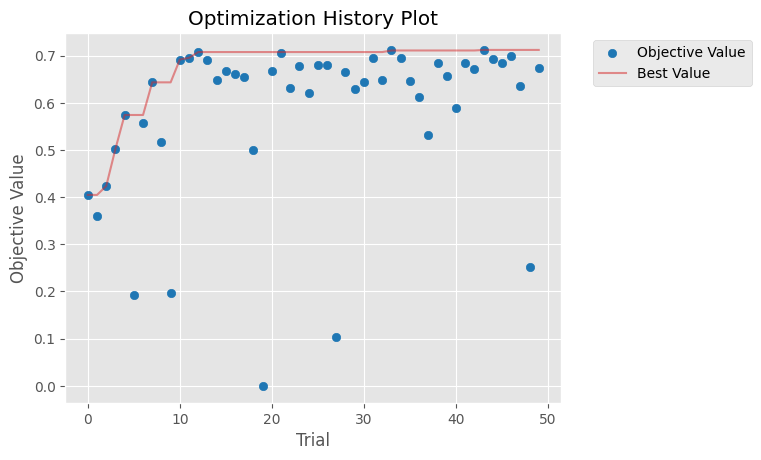

In [8]:
optuna.visualization.matplotlib.plot_optimization_history(study_rf)

<ipython-input-9-1eb49e18946d>:4: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_rf)
<ipython-input-9-1eb49e18946d>:6: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_matplotlib.plot_optimization_history(study_rf)


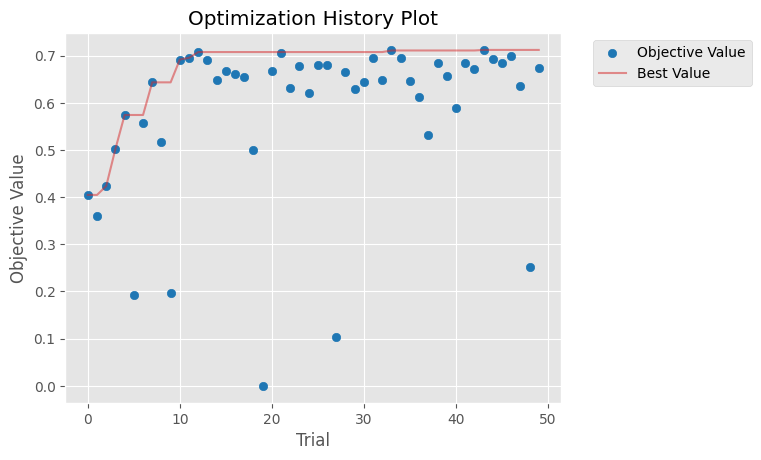

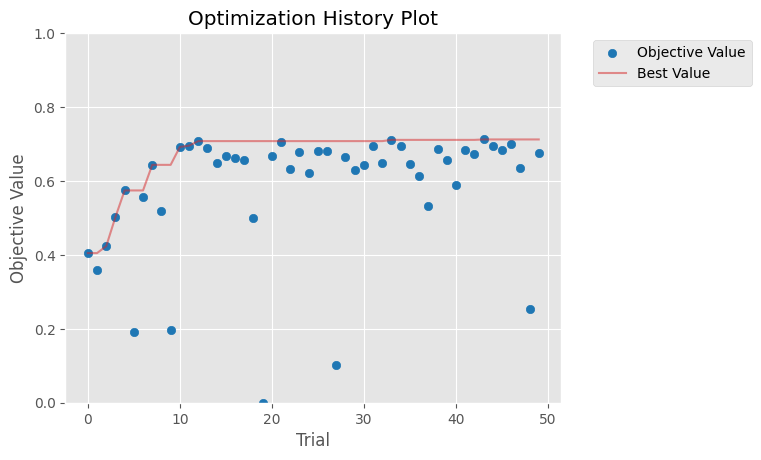

In [9]:
from optuna.visualization import matplotlib as optuna_matplotlib
import matplotlib.pyplot as plt
# Plot the optimization history in a different format
optuna.visualization.matplotlib.plot_optimization_history(study_rf)

optuna_matplotlib.plot_optimization_history(study_rf)

plt.ylim(0, 1)

plt.show()